# Snapshot Ensembles experiments

Построим ансамбль моделей для классификации MNIST, воспользовавшись концепцией 'Train 1, get M for free', описанной в статье https://arxiv.org/abs/1704.00109

![title](1.png)

В стандартном подходе модель заканчивает обучение, сойдясь к некоторому локальному миинимуму (на рисунке слева). Для построения ансамбля весь процесс обучения несколько раз с нуля.

Авторы Snapshot Ensembling используют циклический лернинг рейт, что позволяет модели посетить несколько различных локальных минимумов на протяжении обучения (на рисунке справа).  В этих точках сохраняются "слепки" модели, которые будут использоваться на тесте для построения ансамбля.

In [1]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICES = 1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import sys

import numpy as np
import os
import blosc

import tensorflow as tf
import matplotlib.pyplot as plt

import os
import blosc

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

sys.path.append("..")

from dataset import DatasetIndex, Dataset
from dataset import Batch, action, model, inbatch_parallel
from ensemble_resnet_batch import MnistBatch
from ensemble_resnet_batch import draw_stats

## Загрузим данные MNIST

In [3]:
src = './../task_03//'

with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    full_imgs = blosc.unpack_array(file.read())
    
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    full_labs = blosc.unpack_array(file.read())
    
src = (np.reshape(full_imgs, (65000, 28, 28)), full_labs)

# LEN_MNIST = 65000
# indy = DatasetIndex(np.arange(LEN_MNIST))

# mnistset = Dataset(indy, batch_class=MnistBatch)
# mnistset.cv_split([0.9, 0.1])

ix = DatasetIndex(range(58500))
train_dataset = Dataset(ix, MnistBatch)


## Обучим модель на протяжении 2000 итераций с периодическим лернинг рейтом:

\begin{align}
\alpha(t) = \frac{\alpha_0}{2} \left( \cos \left( \frac{\pi mod(t-1, [T/M])}{[T/M]} \right) + 1 \right) \in [\alpha_0, 0]
\end{align}

## И сохраним $m$ промежуточных моделей на диск

In [4]:
stats = []
loss_history = []
train_accs = []
train_loss_history = []

In [5]:
alpha = 0.1
period = 400
n_iterations = 3200

In [6]:
config = {'resnet':{'period':period, 'n_iterations':n_iterations, 'alpha':alpha}}

In [7]:
# pipeline for train
ppl = (train_dataset.pipeline(config=config).
#        load(src=src, fmt='ndarray').
       train_res(train_loss_history, train_accs, src[0][:58500], full_labs[:58500]))

# # pipeline for test
# ppl_test = (mnistset.test.pipeline().
#             load(src=src, fmt='ndarray').
#             update_stats(sess, stats, loss_history))

In [8]:
for i in tqdm(range(n_iterations)):
    ppl.next_batch(100, n_epochs=None, shuffle=2)

## Loss на train:

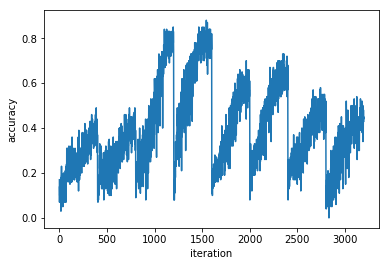

In [9]:
draw_stats(train_accs, '')

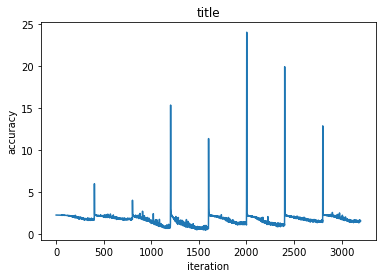

In [10]:
plt.title('title')
plt.plot(train_loss_history[:] )
# for i in range(7):
#     plt.axvline(x=i*10, c='r')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

## Для получения результатов ансамбля $m$ моделей, загрузим сохраненные модели и усредним выходы $softmax$ слоев каждой модели

In [11]:
ix_test = DatasetIndex(range(65000 - 58500))
test_dataset = Dataset(ix_test, MnistBatch)

In [12]:
ensemble_stats = []
ensemble_loss_history = []

# pipeline for ensemble test
ppl_ens_test = (test_dataset.pipeline(config).
            update_stats_ensemble(config, ensemble_stats, ensemble_loss_history, src[0][58500:], src[1][58500:]))

In [13]:
for i in tqdm(range(65)):
    ppl_ens_test.next_batch(100, n_epochs=None)

currently loading trained+400/model-400.meta
INFO:tensorflow:Restoring parameters from trained+400/model-400
currently loading trained+800/model-800.meta
INFO:tensorflow:Restoring parameters from trained+800/model-800
currently loading trained+1200/model-1200.meta
INFO:tensorflow:Restoring parameters from trained+1200/model-1200
currently loading trained+1600/model-1600.meta
INFO:tensorflow:Restoring parameters from trained+1600/model-1600
currently loading trained+2000/model-2000.meta
INFO:tensorflow:Restoring parameters from trained+2000/model-2000
currently loading trained+2400/model-2400.meta
INFO:tensorflow:Restoring parameters from trained+2400/model-2400
currently loading trained+2800/model-2800.meta
INFO:tensorflow:Restoring parameters from trained+2800/model-2800
currently loading trained+3200/model-3200.meta
INFO:tensorflow:Restoring parameters from trained+3200/model-3200



## В итоге лосс ансамбля моделей (исключая 400-ую итерацию) (после красной черты) не слишком улучшает результат:

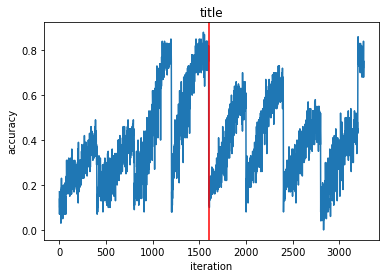

In [14]:
plt.title('title')
plt.plot(train_accs + ensemble_stats)
plt.axvline(x=1601, c='r')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

In [18]:
np.mean(np.array(train_accs[1500:1550]))

0.78680003

In [19]:
np.mean(np.array(ensemble_stats))

0.7712307

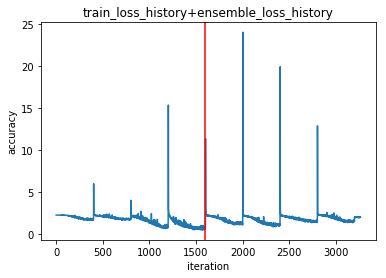

In [15]:
plt.title('train_loss_history+ensemble_loss_history')
plt.plot(train_loss_history + ensemble_loss_history)
plt.axvline(x=1601, c='r')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

## Вопреки ожиданиям усреднение нескольких глобальных минимумов не улучшило, а напротив, ухудшило результат. Думаю, стоит попробовать другой способ агрегирования результатов нескольких моделей (например, максимум).
